In [3]:
def plot_grid_search_2d(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
# Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1),len(grid_param_2))
    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_1):
        ax.plot(grid_param_2, scores_mean[idx,:], '-o', label= name_param_1 + ': ' + str(val))
        ax.set_title("Grid Search Scores", fontsize=12, fontweight='bold')
        ax.set_xlabel(name_param_2, fontsize=10)
        ax.set_ylabel('CV Average Validation Accuracy', fontsize=10)
        ax.legend(loc="best", fontsize=8)
        ax.grid('on')

In [4]:
### Function to visualize the results of Grid Search with 3 hyperparameters ###
def plot_grid_search_3d(cv_results, grid_param_1, grid_param_2, grid_param_3, name_param_1, name_param_2, name_param_3):
    """
    Plots a grid search result for 3 hyperparameters as a series of 2D plots (one for each value of grid_param_3).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    scores_mean = np.array(cv_results['mean_test_score'])
    # Reshape to (len(grid_param_1), len(grid_param_2), len(grid_param_3))
    scores_mean = scores_mean.reshape(len(grid_param_1), len(grid_param_2), len(grid_param_3))

    for idx3, val3 in enumerate(grid_param_3):
        _, ax = plt.subplots(1, 1, figsize=(7, 5))
        for idx1, val1 in enumerate(grid_param_1):
            ax.plot(grid_param_2, scores_mean[idx1, :, idx3], '-o', label=f"{name_param_1}: {val1}")
        ax.set_title(f"Grid Search Scores ({name_param_3}: {val3})", fontsize=12, fontweight='bold')
        ax.set_xlabel(name_param_2, fontsize=10)
        ax.set_ylabel('CV Average Validation Accuracy', fontsize=10)
        ax.legend(loc="best", fontsize=8)
        ax.grid(True)
        plt.show()

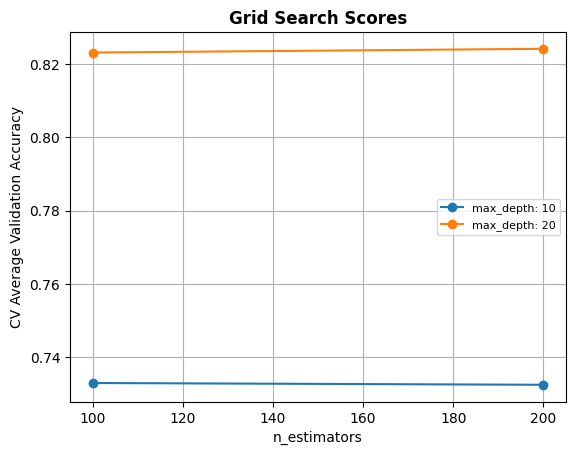

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

balanced_data = pd.read_csv("balanced_data.csv")
# Features und Ziel
X = balanced_data.drop(columns='target')
Y = balanced_data['target']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size = 0.2, random_state=22)

# Klassifikationsmodell
RForClassCV = RandomForestClassifier(random_state=0)
#gini und anderes ausporbieren
# Grid definieren
param_grid = {
    'max_depth': [30,40,50],
    'n_estimators': [100,200,300,400,500],
    'criterion': ['gini'],
    'min_samples_leaf': [1]
}

# GridSearchCV Setup
model = RandomForestClassifier(random_state=0)
grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid.fit(X_train, Y_train)

# Plot aufrufen
import matplotlib.pyplot as plt
plot_grid_search_2d(grid.cv_results_, param_grid['max_depth'], param_grid['n_estimators'],'max_depth', 'n_estimators')

plt.show()

In [6]:
# Klassifikationsmodell mit besten Parametern aus CV
final_rf_clf = RandomForestClassifier(random_state=0)
final_rf_clf.set_params(**grid.best_params_)

# Modell trainieren
final_rf_clf.fit(X_train, Y_train)

# Accuracy auf Trainings- und Testdaten berechnen
train_acc = final_rf_clf.score(X_train, Y_train)
test_acc = final_rf_clf.score(X_test, Y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9438
Test Accuracy: 0.8229


In [7]:
from sklearn.metrics import classification_report
prediction = final_rf_clf.predict(X_test)
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           1       0.79      0.86      0.82      1375
           2       0.67      0.65      0.66      1375
           3       0.68      0.62      0.65      1375
           4       0.74      0.84      0.79      1375
           5       0.98      0.98      0.98      1375
           6       0.92      0.89      0.91      1375
           7       0.82      0.83      0.83      1375
           8       0.91      0.88      0.89      1375
           9       0.89      0.87      0.88      1375

    accuracy                           0.82     12375
   macro avg       0.82      0.82      0.82     12375
weighted avg       0.82      0.82      0.82     12375



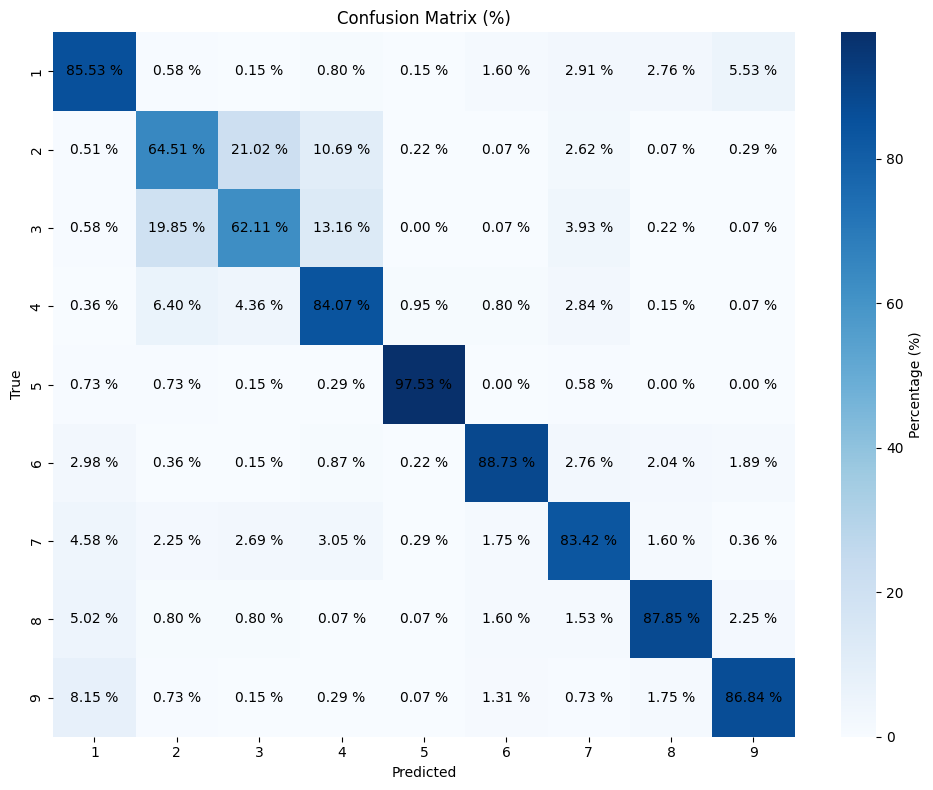

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, prediction)
label_names = sorted(balanced_data['target'].unique())

# In Prozent umrechnen (pro Zeile)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names,
            cbar_kws={'label': 'Percentage (%)'},
            annot_kws={"fontsize": 10, "va": "center", "ha": "center", "color": "black"})
for t in plt.gca().texts:
    t.set_text(t.get_text() + " %")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (%)")
plt.tight_layout()
plt.show()

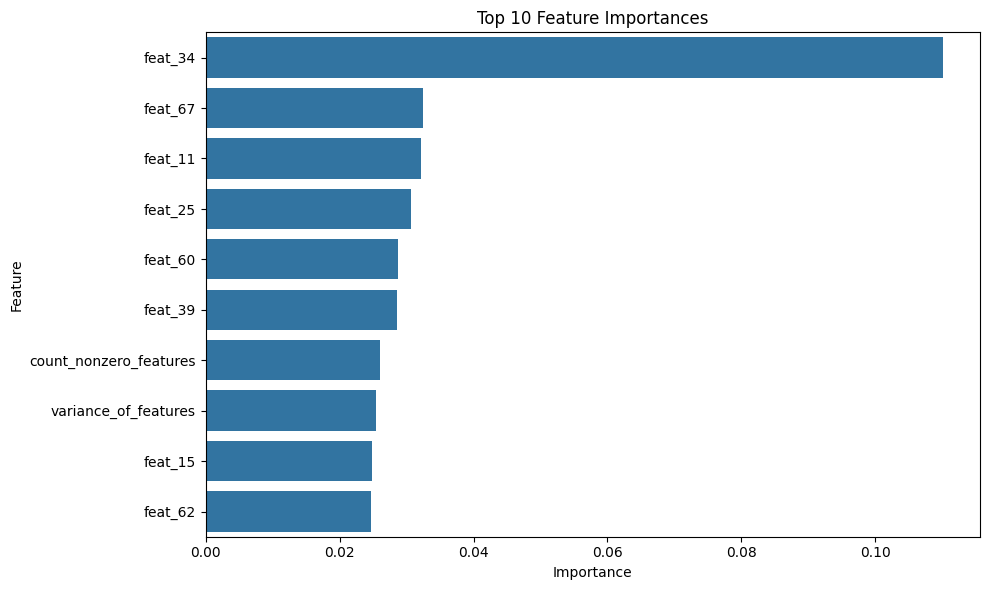

In [9]:
importances = final_rf_clf.feature_importances_
indices = np.argsort(importances)[::-1][:10]  # Top 20 features

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    final_rf_clf, X, Y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Train", marker='o')
plt.plot(train_sizes, test_mean, label="Validation", marker='o')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 